# French Text Clustering

This notebook shows how to perform text clustering in French, using the [CamemBERT](https://camembert-model.fr/) language model. 

As an example, I'm clustering Amazon purchases to see how much is spent in each category. But you could use this for any other use case, including the clustering of questions/comments/tweets, etc.

## Data preparation

### Import data

In [ ]:
import pandas as pd

In [2]:
# Replace with your own path
dataset_path = "Resources/amazondata.xlsx"

# Use read_excel or read_csv depending on your dataset format
df = pd.read_excel(dataset_path)
# df = pd.read_csv(dataset_path)

df = df.reset_index()
df

,index,Item,Quantity,Price
0,0,Toruiwa 4x Boule de Lavage Balle à Billes Réut...,1,1.59
1,1,Crazy Color Coloration Semi-Permanente 100ml (...,2,8.78
2,2,NOVAGO Filet à Linge (Sac de Lavage) en Mailla...,1,2.79
3,3,Elementary saison 6 [2019],1,39.99
4,4,"Eono by Amazon - Sacs Réutilisables en Maille,...",1,12.99
5,5,KingYH 6 Pièces Crochet de Suspension avec Bas...,3,11.49
6,6,"FayTun [Lot de 2 Verre Trempé Galaxy Note 9, P...",1,8.99
7,7,HP Sprocket Imprimante Photo portable Blanc,1,129.00
8,8,"VARIOSAN Tuyau d'alimentation, 3/4, rallonge p...",1,12.47
9,9,Microsoft kit de mine pour Stylet Surface,1,14.99


### Text processing

In [ ]:
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_en = stopwords.words()
stop_words_fr = stopwords.words('french')
stop_words = stop_words_en + stop_words_fr 

def process_text(value):
    
    try:
         # Remove digits
        value = re.sub(r'\d','',value)
        # Remove punctuation, unnecessary whitespaces, and convert to lower case
        value = value.encode('utf-8', 'ignore').decode('utf-8')
        value = re.sub(r'\s+', ' ', value.strip()
                                .lower()
                                .translate(str.maketrans(string.punctuation,
                                                         ' ' * len(string.punctuation))))

        # Remove stop words and unnecessary words
        words = value.split(' ')
        value = ' '.join(w for w in words if (not w in stop_words) and (len(w) > 2))
        
    except Exception as e:
        print(f"Error: {e}")
    
    return value    

In [4]:
df['text'] = df['Item'].apply(lambda x: process_text(x))
df.head()

,index,Item,Quantity,Price,text
0,0,Toruiwa 4x Boule de Lavage Balle à Billes Réut...,1,1.59,toruiwa boule lavage balle billes réutilisable...
1,1,Crazy Color Coloration Semi-Permanente 100ml (...,2,8.78,crazy color coloration semi permanente rose gold
2,2,NOVAGO Filet à Linge (Sac de Lavage) en Mailla...,1,2.79,novago filet linge sac lavage maillage double ...
3,3,Elementary saison 6 [2019],1,39.99,elementary saison
4,4,"Eono by Amazon - Sacs Réutilisables en Maille,...",1,12.99,eono amazon sacs réutilisables maille respectu...


### Feature extraction

In [ ]:
import torch
import numpy as np

# Loading CamemBERT model
camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

In [6]:
def camembert_embed(text):
    tokens = camembert.encode(text)
    with torch.no_grad():
        encoded_layers = camembert.extract_features(tokens,return_all_hiddens=True)
    token_embeddings = torch.stack(encoded_layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    sum_vec = torch.sum(token_embeddings[-4:], dim=0)
    sentence_embedding = torch.mean(sum_vec,dim=0)
    array = sentence_embedding.detach().numpy()
    return array

In [7]:
df['tokens'] = df['text'].apply(lambda x: camembert_embed(x))
df.head()

,index,Item,Quantity,Price,text,tokens
0,0,Toruiwa 4x Boule de Lavage Balle à Billes Réut...,1,1.59,toruiwa boule lavage balle billes réutilisable...,"[0.094937205, 0.40437862, 0.64395005, 0.425695..."
1,1,Crazy Color Coloration Semi-Permanente 100ml (...,2,8.78,crazy color coloration semi permanente rose gold,"[0.010742732, 0.09468272, 0.38741916, -0.25734..."
2,2,NOVAGO Filet à Linge (Sac de Lavage) en Mailla...,1,2.79,novago filet linge sac lavage maillage double ...,"[-0.079681136, 0.27427655, -0.20962901, 0.6143..."
3,3,Elementary saison 6 [2019],1,39.99,elementary saison,"[-0.035657156, 0.13503872, 0.59852403, 0.00063..."
4,4,"Eono by Amazon - Sacs Réutilisables en Maille,...",1,12.99,eono amazon sacs réutilisables maille respectu...,"[-0.038375758, 0.370895, -0.090504326, 0.30514..."


## Clustering

Iterate and change the cluster size until you're satisfied with the results. If your number of clusters is high, there's a good chance that you will get different clusters each time.

In [8]:
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [9]:
# Change the number of clusters here
NUM_CLUSTERS = 12

X = df['tokens'].tolist()

In [10]:
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [11]:
print ("Cluster id labels for input data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for input data
[ 4  8  4  1  4 10  3  6  5  6  3 10  3  0  0  0  7  3  1  5  3  1 10 10
  9  3  3  3  3 11  9 10  6  6 10  2 11  7  0  8]
Centroids data
[[ 0.03228523  0.11342703 -0.31404456 ... -0.00709393 -0.16297639
  -0.1888255 ]
 [ 0.14208831  0.19427816  0.16860331 ... -0.25306524 -0.20683701
  -0.71428427]
 [ 0.53062612  0.87588549 -0.00091281 ...  0.1534079   0.20460872
  -0.78885382]
 ...
 [ 0.12231219  0.57682276 -0.33152841 ... -0.05735072  0.03343454
  -0.73263559]
 [-0.14583981  0.27161744 -0.11566754 ...  0.02890268 -0.02589778
  -0.39343421]
 [-0.14125998 -0.11455892 -0.00606462 ... -0.09972431  0.00550447
  -0.51425553]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-1067.028313407725
Silhouette_score: 
0.13330714


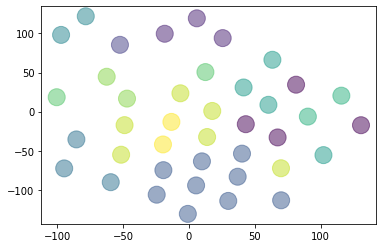

In [12]:
model_tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model_tsne.fit_transform(X)
 
 
plt.scatter(Y[:, 0], Y[:, 1],c=labels, s=290,alpha=.5)
 
plt.show()

### Results

In [13]:
df['cluster_id'] = df['index'].apply(lambda x: labels[x])
df['cluster_size'] = df.groupby('cluster_id')['cluster_id'].transform('count')
df_sorted = df.sort_values(by=['cluster_size','cluster_id'],ascending=False)
df_sorted

,index,Item,Quantity,Price,text,tokens,cluster_id,cluster_size
6,6,"FayTun [Lot de 2 Verre Trempé Galaxy Note 9, P...",1,8.99,faytun lot verre trempé galaxy note protege éc...,"[-0.05953239, -0.07122753, -0.6673771, 0.07494...",3,9
10,10,"JETech Protection Écran Galaxy Note 9, Film Ul...",1,6.97,jetech protection écran galaxy note film ultra...,"[-0.22772099, 0.7063208, -0.5604057, 0.0268300...",3,9
12,12,TAMOWA [2 pièces Verre Trempé pour Samsung Gal...,1,9.99,tamowa pièces verre trempé samsung galaxy note...,"[-0.05863396, 0.8211037, -0.5954391, 0.3395086...",3,9
17,17,ChasBete Surface Book et 2017 Release Surface ...,1,12.99,chasbete surface book release surface book dec...,"[-0.11034911, 1.1856052, -0.45038033, 0.141654...",3,9
20,20,Hezbjiti [2-Pack pour Samsung Galaxy Note 9 Pr...,1,8.96,hezbjiti pack samsung galaxy note protection e...,"[0.019521466, 0.6870391, -0.60198873, 0.105805...",3,9
25,25,"KOUYI Coque Samsung Galaxy Note 9, Luxe Flotta...",1,6.99,kouyi coque samsung galaxy note luxe flottant ...,"[-0.030719142, 0.59316623, -0.12558705, -0.055...",3,9
26,26,AYUBMR [2 Pièce] Verre Trempé pour Samsung Gal...,1,8.99,ayubmr pièce verre trempé samsung galaxy note ...,"[-0.16540459, 0.62309515, -0.61095876, 0.32534...",3,9
27,27,AILZH Coque Samsung Galaxy Note 9 Étui 360 deg...,1,9.98,ailzh coque samsung galaxy note étui degrés ho...,"[-0.0129593555, 0.5913579, -0.705017, -0.10816...",3,9
28,28,TAURI Protection écran pour Samsung Galaxy Not...,1,10.99,tauri protection écran samsung galaxy note cou...,"[-0.27359772, 0.611074, -0.41079322, 0.1343652...",3,9
5,5,KingYH 6 Pièces Crochet de Suspension avec Bas...,3,11.49,kingyh pièces crochet suspension base ronde ac...,"[0.12286453, 0.58353746, 0.0700437, 0.06174605...",10,6


In [14]:
def get_total(cluster):
    total = 0
    for item in cluster:
        total += int(item['quantity']) * float(item['price'])
    return total

In [15]:
clusters = {}

for index, row in df_sorted.iterrows():
    
    item = {}
    item['name'] = row['Item']
    item['price'] = row['Price']
    item['quantity'] = row['Quantity']
    
    cluster_id = 'cluster_'+ str(row['cluster_id'])
    try:
        clusters[cluster_id].append(item)
    except:
        clusters[cluster_id] = [item]
    

for key in clusters.keys():
    print(f"\n{key}\n")
    for item in clusters[key]:
        print(f"{item['quantity']} {item['name']} - {item['price']}\n")
    total = get_total(clusters[key])
    print(f"TOTAL: {total}\n")


cluster_3

1 FayTun [Lot de 2 Verre Trempé Galaxy Note 9, Protege Écran pour Galaxy Note 9, Ultra Transparent - 8.99

1 JETech Protection Écran Galaxy Note 9, Film Ultra HD TPU, Coque Compatible, Lot de 2 - 6.97

1 TAMOWA [2 pièces Verre Trempé pour Samsung Galaxy Note 9, Film Protection en Verre trempé Écran Protecteur Vitre - Ultra Résistant Dureté 9H - 9.99

1 ChasBete Surface Book et 2017 Release Surface Book 2 Decal Peau Marbre Grain Protecteur Vinyle Autocollant Couverture Précision pour Surface - 12.99

1 Hezbjiti [2-Pack pour Samsung Galaxy Note 9 Protection ecran, Film de Protection d'écran en Verre trempé [Anti-Rayures] [HD Clair] [sans Bulle] - 8.96

1 KOUYI Coque Samsung Galaxy Note 9, Luxe Flottant Liquide Noir Étui Protecteur TPU Bumper Cover Bling Mode 3D Créatif Conception Coque Housse Telephone - 6.99

1 AYUBMR [2 Pièce] Verre Trempé pour Samsung Galaxy Note 9 , 3D Touch Dureté 9H Film Protection, [Anti-empreinte digitale] Protection Écran pour Samsung - 8.99

1 AILZH